In [222]:
import pandas as pd
import numpy as np
import sklearn
import json
import matplotlib.pyplot as plot
from wordcloud import WordCloud
%matplotlib inline

## Read in the user metadata file

In [223]:
# user_metadata_file = 'test.json'
# with open(user_metadata_file) as f:
#     users = json.load(f)
#     user_info= pd.DataFrame(users)

# print(len(user_info))

user_metadata_file = 'user_metadata_latest.jsonl'
user_metadata_list = []
with open(user_metadata_file) as fp:
    for line in fp.readlines():
        user_metadata_list.append(json.loads(line))

user_info = pd.DataFrame(user_metadata_list)

Add columns for follows_sg, follows_professional_sg, and follows_thinspo

In [224]:
user_info['follows_sg'] = None
user_info['follows_professional_sg'] = None
user_info['follows_thinspo'] = None
user_info['is_anorexia_recovery'] = None

In [225]:
user_info.head()

created_at                                        description  \
0  2013-01-04 14:14:01  recovering from anorexia. inpatient X1 .life i...   
1  2018-07-13 18:37:04  Tweeting all things MH & positive thoughts whi...   
2  2017-07-17 17:41:33  Jumping on the bandwagon of 'tweet what you ea...   
3  2016-06-06 11:15:49  New TV series seeks 16-19yr olds suffering fro...   
4  2010-02-01 18:36:29  A recovering anorexic simultaneously trying to...   

   favourites_count  followers_count  friends_count                   id  \
0                63             1842            536           1060558130   
1                41               50            213  1017840348083650560   
2                31               32            185   887004356075286528   
3                 9               77            256   739777811964153856   
4                 0             4397           5661            110487555   

    lang  listed_count             location                 name  \
0     en            18           Wonderland  Recovery Vs Relspse   
1     en             0                                flyingfree   
2     en             1  South West, England            Emily May   
3  en-gb             0      London, England            NewEDProg   
4     en           108               London        msjoanna cake   

  profile_location      screen_name  statuses_count time_zone utc_offset  \
0             None      BrokenPurge           18326      None       None   
1             None  flyingf28327022             159      None       None   
2             None      queenofoats              22      None       None   
3             None        NewEDProg             221      None       None   
4             None     msjoannacake            3245      None       None   

   verified follows_sg follows_professional_sg follows_thinspo  \
0     False       None                    None            None   
1     False       None                    None            None   
2     False       None                    None            None   
3     False       None                    None            None   
4     False       None                    None            None   

  is_anorexia_recovery  
0                 None  
1                 None  
2                 None  
3                 None  
4                 None

## Gather information about the number of support groups

In [226]:
support_groups = pd.read_csv('supportgroup.csv', header=1)
print(len(support_groups))
support_groups.head()

35


screen_name is_thinspo is_anorexia_recovery  \
0    cheers_forana       TRUE                False   
1      lifeoverAna      FALSE                 True   
2      BrokenPurge      FALSE                 True   
3          xbertyx      FALSE                 True   
4  flyingf28327022        NaN                  NaN   

                                     professional_sg  \
0                                                NaN   
1  Silencing_ED,EatingRecovery,loveyourbody,EDCar...   
2  AnorexiaDaily,Spreading_L0ve,SelfHarmWIILEnd,A...   
3                       ProjectBuddy,AgainstSuicide    
4                                                NaN   

                                                  sg follows_thinspo  \
0                                                NaN            TRUE   
1  angelaegambrel,ichosetolive,HopefulRecovery,An...           FALSE   
2  scalesR4fish,StandStr0ng,DyingDaisy_,AwareOfSe...            TRUE   
3                                        EndThePain_            TRUE   
4                                                NaN             NaN   

           Notes  
0            NaN  
1            NaN  
2            NaN  
3  Fitness enthu  
4   Private user

In [227]:
professional_sg_set = set()
sg_set = set()

THRESHOLD = 2

for i in range(len(support_groups)):
    screen_name = support_groups.loc[i, 'screen_name']
    
    # can be empty
    idx = user_info.index[user_info['screen_name'] == screen_name]
    
    # get professional support groups
    professional_sg = support_groups.loc[i, 'professional_sg']
    if not pd.isnull(professional_sg) and professional_sg is not '-':
        sgs = list(map(lambda x: x.lower(), professional_sg.split(',')))
        # Classify user as following professional SG if they follow >= THRESHOLD professional SG's
        if not idx.empty:
            user_info.at[idx, 'follows_professional_sg'] = len(sgs) >= THRESHOLD
        professional_sg_set.update(sgs)
    
    # get non-professional support groups
    sg = support_groups.loc[i, 'sg']
    if not pd.isnull(sg) and sg is not '-':
        sgs = list(map(lambda x: x.lower(), sg.split(',')))
        # Classify user as following SG if they follow >= THRESHOLD SG's
        if not idx.empty:
            user_info.at[idx, 'follows_sg'] = len(sgs) >= THRESHOLD
        sg_set.update(sgs)
        
    is_anorexia_recovery = support_groups.loc[i, 'is_anorexia_recovery']
    if not pd.isnull(sg) and sg is not '-':
        if not idx.empty:
            user_info.at[idx, 'is_anorexia_recovery'] = is_anorexia_recovery == True
    
    follows_thinspo = support_groups.loc[i, 'follows_thinspo']
    if not pd.isnull(sg) and sg is not '-':
        if not idx.empty:
            user_info.at[idx, 'follows_thinspo'] = follows_thinspo == 'TRUE'
        sg_set.update(sgs)

print("# professional support groups: {}".format(len(professional_sg_set)))
print("# non-professional support_groups: {}".format(len(sg_set)))

# professional support groups: 102
# non-professional support_groups: 106


Classify the users in the users_info data frame as following professional support groups, non-professional support groups, or neither

In [228]:
# Verify that the new columns are populated
user_info.head()

created_at                                        description  \
0  2013-01-04 14:14:01  recovering from anorexia. inpatient X1 .life i...   
1  2018-07-13 18:37:04  Tweeting all things MH & positive thoughts whi...   
2  2017-07-17 17:41:33  Jumping on the bandwagon of 'tweet what you ea...   
3  2016-06-06 11:15:49  New TV series seeks 16-19yr olds suffering fro...   
4  2010-02-01 18:36:29  A recovering anorexic simultaneously trying to...   

   favourites_count  followers_count  friends_count                   id  \
0                63             1842            536           1060558130   
1                41               50            213  1017840348083650560   
2                31               32            185   887004356075286528   
3                 9               77            256   739777811964153856   
4                 0             4397           5661            110487555   

    lang  listed_count             location                 name  \
0     en            18           Wonderland  Recovery Vs Relspse   
1     en             0                                flyingfree   
2     en             1  South West, England            Emily May   
3  en-gb             0      London, England            NewEDProg   
4     en           108               London        msjoanna cake   

  profile_location      screen_name  statuses_count time_zone utc_offset  \
0             None      BrokenPurge           18326      None       None   
1             None  flyingf28327022             159      None       None   
2             None      queenofoats              22      None       None   
3             None        NewEDProg             221      None       None   
4             None     msjoannacake            3245      None       None   

   verified follows_sg follows_professional_sg follows_thinspo  \
0     False       True                    True            True   
1     False       None                    None            None   
2     False       True                    True           False   
3     False       None                    None            None   
4     False       None                    True            None   

  is_anorexia_recovery  
0                 True  
1                 None  
2                 True  
3                 None  
4                 None

Drop the rows that have protected twitter accounts

In [193]:
user_info = user_info[user_info.follows_sg.notnull()]

In [57]:
from TweetPreprocessor import TweetPreprocessor

def get_support_groups_from_list(followers):
    support_groups = []
    for follower in followers:
        description, verified = TweetPreprocessor.pipeline(follower['description'].lower()), follower['verified']
        print(description)
    return support_groups

In [58]:
cols = ['description', 'verified', 'friend_id', 'associated_screen_name']
rows = []

num_users = user_info.shape[0]

for i in range(num_users):
    friends = user_info.iloc[i].followers
    screen_name = user_info.iloc[i].screen_name
    if isinstance(friends, list):
        print("{} has {} friends".format(screen_name, len(friends)))
        for friend in friends:
            # only want english speaking
            if 'en' in friend['lang']:
                description, verified = TweetPreprocessor.pipeline(friend['description'].lower()), friend['verified']
                rows.append([description, verified, friend['id'], screen_name])
            
followers_df = pd.DataFrame(rows)
followers_df.columns = cols
print("\nFound {} friends".format(followers_df.shape[0]))
followers_df.head()

AttributeError: 'Series' object has no attribute 'followers'

In [59]:
# Try some unsupervised learning to classify the users based on description
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
n_clusters = 3

vectorizer = TfidfVectorizer(max_df=0.5, max_features=10000,
                                 min_df=2, stop_words='english')
X = vectorizer.fit_transform(followers_df.description)

km = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=100, n_init=1)
labels = km.fit_predict(X)
print("KMeans with {} clusters fit".format(n_clusters))
print(labels)
assert(len(labels) == followers_df.shape[0])
for i in range(followers_df.shape[0]):
    followers_df.loc[i, 'class'] = labels[i]
followers_df[['description', 'class']]

for i in range(n_clusters):
    class_df = followers_df[followers_df['class'] == i]
    print("=" * 20, "Class number {}: ({} users)".format(i, class_df.shape[0]), "=" * 20)
    print(class_df.head())

NameError: name 'followers_df' is not defined

In [60]:
dump = user_info[['description','statuses_count', 'screen_name', 'followers']]

KeyError: "['followers'] not in index"

In [61]:
dump

NameError: name 'dump' is not defined

# Reading in Tweets file

In [229]:
tweet_file = 'user_tweets_latest.jsonl'
tweet_train = []
with open(tweet_file) as fp:
    for line in fp.readlines():
        tweet_train.append(json.loads(line))

In [230]:
tweets = pd.DataFrame(tweet_train)

In [233]:
tweets['tweeter_screen_name'].unique()

array(['HanBaNannz', 'elamame_bean', 'msjoannacake', 'cheers_forana',
       'AdriennesAngels', 'xbertyx', 'queenofoats', 'NewEDProg',
       'BrokenPurge', 'recover_me143', 'madison_summer', 'lifeoverAna',
       'health_turtle', 'Jenny_MT', 'stuckinbetween_', 'emmyrexia',
       'belle_va', 'BeSkinny_', 'Silencing_ED', 'claire_santucci',
       'edfree_chelsey', 'AnaSurvivor', 'angelaegambrel', 'Tryingforfit',
       'RealityTweeter', 'eatdisorderhelp', 'AshleyVargas731',
       'FitspoKickBoxer'], dtype=object)

Drop tweets with urls because I noticed that a lot of people are putting spam tweets such as:
"My daily stats: 19 new followers, 5 new unfollowers via http://t.co/LYJ6IqurZF

In [197]:
def drop_tweets_with_urls(df):
    num_dropped = 0
    print(len(df))
    for i in range(df.shape[0]):
        urls = df.at[i, 'entities']['urls']
        if len(urls) > 0:
            df.drop(i, inplace=True)
            num_dropped += 1
    print("Dropped {}".format(num_dropped))
    df.reset_index(inplace=True)
    print(len(df))
    return df

In [198]:
tweets = drop_tweets_with_urls(tweets)

9076
Dropped 2318
6758


In [199]:
# TODO: Classify the users as having a support group or not

### Sentiment Analysis

In [234]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from imp import reload
import TweetPreprocessor
reload(TweetPreprocessor)
from TweetPreprocessor import TweetPreprocessor 

analyser = SentimentIntensityAnalyzer()

def analyse_sentiment(tweeter, preprocess=False):
    for i in range(0, tweeter.shape[0]):
        text = tweeter.iloc[i].text
        np_score = analyser.polarity_scores(text)
        
        preprocessed_text = TweetPreprocessor.pipeline(text)
        score = analyser.polarity_scores(preprocessed_text)
        
        tweeter.loc[i, 'processed_text'] = preprocessed_text
        
        tweeter.loc[i, 'compound'] = score['compound']
        tweeter.loc[i, 'pos'] = score['pos']
        tweeter.loc[i, 'neg'] = score['neg']
        tweeter.loc[i, 'neu'] = score['neu']
        
        tweeter.loc[i, 'compound_np'] = np_score['compound']
        tweeter.loc[i, 'pos_np'] = np_score['pos']
        tweeter.loc[i, 'neg_np'] = np_score['neg']
        tweeter.loc[i, 'neu_np'] = np_score['neu']      
    return tweeter


[nltk_data] Downloading package wordnet to /Users/jtsui/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [235]:
analysed_users = analyse_sentiment(pd.DataFrame(tweets))

In [236]:
analysed_users[['processed_text', 'text']].head()

processed_text  \
0  whenever i talk negatively about my recovering...   
1                                             coffee   
2   lillard rock bottom will teach you lessons th...   
3                                        white folks   
4          a story in  pictures littlesister gogreen   

                                                text  
0  Whenever I talk negatively about my recovering...  
1   RT @CassTolliver: Coffee https://t.co/3e7SL6oBQ8  
2  RT @Dame_Lillard: Rock bottom will teach you l...  
3  RT @PatMcAfeeShow: White folks https://t.co/Bu...  
4  RT @BarstoolMSU: A story in 4 pictures\n\n#Lit...

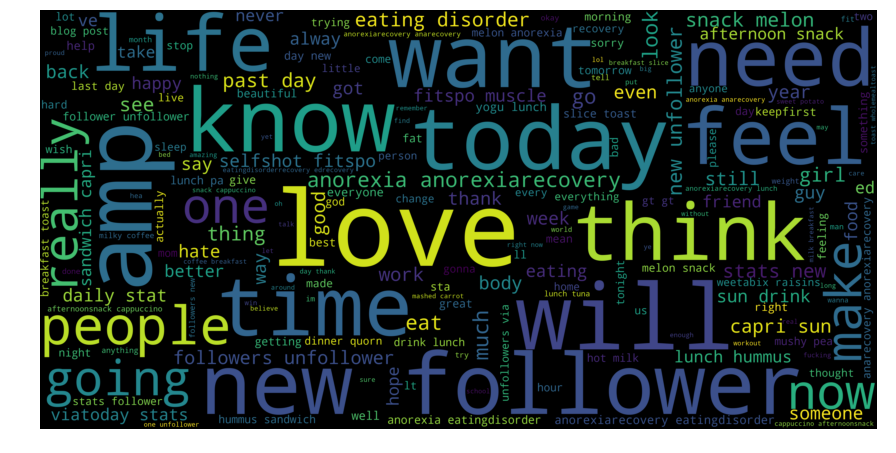

In [237]:
wordcloud_string = ''
for i in range(analysed_users.shape[0]):
    wordcloud_string += analysed_users.iloc[i].processed_text

wordcloud = WordCloud(width=4000, height=2000,max_font_size=500).generate(wordcloud_string)
plot.figure(figsize=(15,12))
plot.imshow(wordcloud, interpolation="bilinear")
plot.axis("off")
plot.show()

wordcloud.to_file("wordcloud.png")

### Topic Modeling

In [238]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(stop_words='english')
tfidf_result = vec.fit_transform(analysed_users.processed_text)
feature_names = vec.get_feature_names()

tfidf_result.shape

(51873, 18442)

In [239]:
def top_n(tfidf_result, feature_names, top=100):
        if feature_names is None or tfidf_result is None:
            return

        scores = zip(feature_names,
                     np.asarray(tfidf_result.sum(axis=0)).ravel())

        sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)

        labels, scores = [], []

        # Get the scores and labels of the top 100 tweets
        for item in sorted_scores[:top]:
            print("{0:50} Score: {1}".format(item[0], item[1]))
            # sns.distplot(item[1], label=item[0])
            labels.append(item[0])
            scores.append(item[1])

        index = np.arange(len(scores))
        plot.bar(index, scores, figure=plot.figure(figsize=(25, 10)))
        plot.xlabel('Word', fontsize=24)
        plot.ylabel('TFIDF Score', fontsize=24)
        plot.xticks(index, labels, fontsize=12, rotation=90)
        plot.title('Top {} features'.format(top))
        plot.savefig('Top_{}'.format(top))

new                                                Score: 860.6740771898646
day                                                Score: 639.1954103676005
news                                               Score: 625.3432932592398
just                                               Score: 621.6714261040319
love                                               Score: 584.6642540344251
lunch                                              Score: 498.6567927021347
stats                                              Score: 496.8953078430325
like                                               Score: 490.7646929985054
today                                              Score: 475.13976543211504
thank                                              Score: 436.73513400287237
unfollowers                                        Score: 432.920437057114
dinner                                             Score: 431.41596535865966
followers                                          Score: 422.880102640279
anorexia   

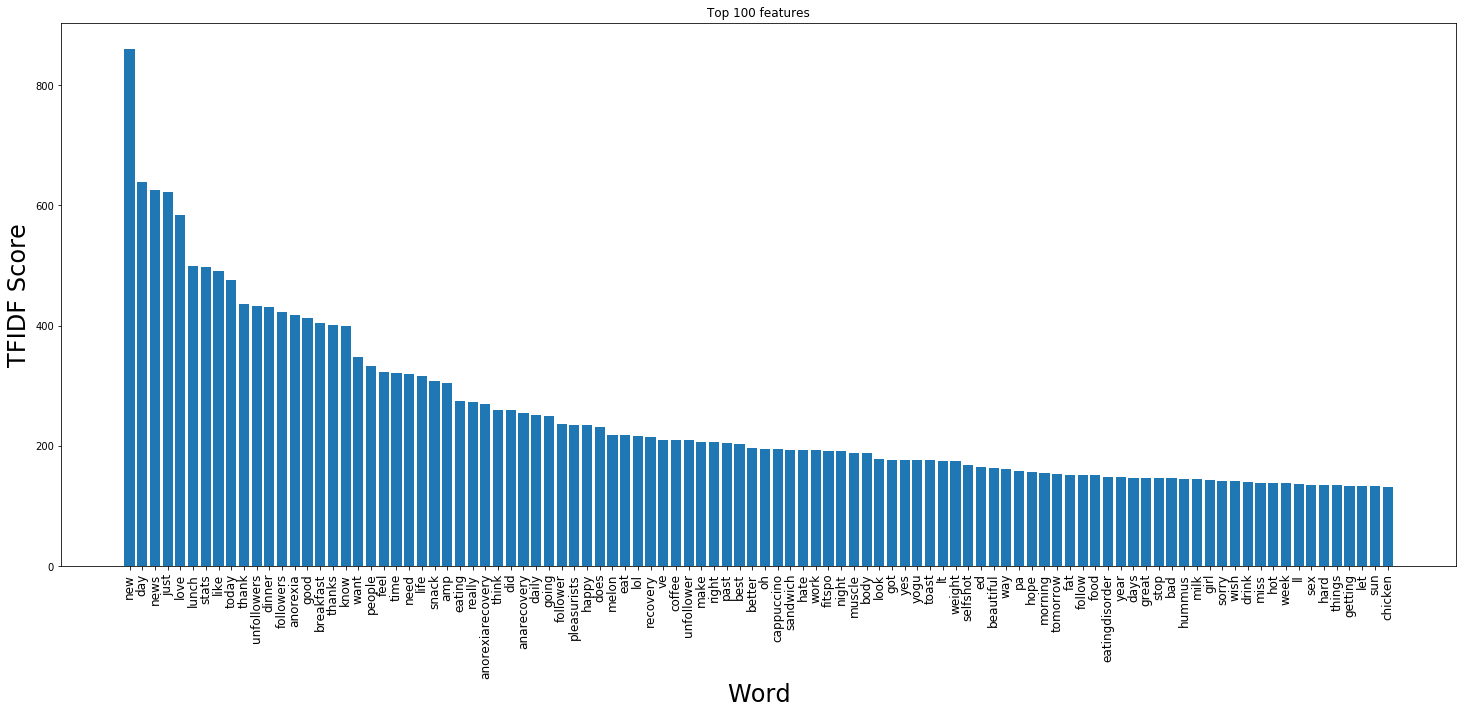

In [240]:
top_n(tfidf_result, feature_names, top=100)

In [241]:
# Topic Modeling
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD

num_topics = 10

lda_model = LatentDirichletAllocation(n_topics=num_topics, max_iter=10, learning_method='online')
lda_Z = lda_model.fit_transform(tfidf_result)
print('LDA shape: ')
print(lda_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)

# Build a Non-Negative Matrix Factorization Model
nmf_model = NMF(n_components=num_topics)
nmf_Z = nmf_model.fit_transform(tfidf_result)
print('NMF shape: ')
print(nmf_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)

# Build a Latent Semantic Indexing Model
lsi_model = TruncatedSVD(n_components=num_topics)
lsi_Z = lsi_model.fit_transform(tfidf_result)
print('LSI shape: ')
print(lsi_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)


/Users/jtsui/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:294: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LDA shape: 
(51873, 10)
NMF shape: 
(51873, 10)
LSI shape: 
(51873, 10)


In [242]:
def print_topics(model, top_n=10):
        for idx, topic in enumerate(model.components_):
            print("Topic %d:" % (idx))
            print([(vec.get_feature_names()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]])

In [243]:
# Let's see how the first document in the corpus looks like in different topic spaces
print("LDA Model:")
print("=" * 20)
print_topics(lda_model)
print("=" * 20, '\n')

print("NMF Model:")
print("=" * 20)
print_topics(nmf_model)
print("=" * 20, '\n')

print("LSI Model:")
print("=" * 20)
print_topics(lsi_model)
print("=" * 20, '\n')

LDA Model:
Topic 0:
[('hate', 197.08955826288437), ('follow', 191.66694146541622), ('god', 163.1682397329895), ('body', 160.7839977224383), ('pleasurists', 154.71871222497586), ('pa', 142.42663115865565), ('healthy', 140.77154249494396), ('does', 138.66634386132253), ('true', 136.61187829769395), ('miss', 135.77220346372178)]
Topic 1:
[('work', 233.8433903333022), ('fit', 134.75058382416205), ('yeah', 117.16203030005171), ('stop', 112.65317016374759), ('disorders', 111.29259048560526), ('let', 106.61874712953114), ('guy', 96.68025998809668), ('talk', 92.43466618566897), ('stay', 87.43076452077703), ('new', 85.105593676138)]
Topic 2:
[('feel', 330.875029493857), ('snack', 241.5773342407276), ('like', 193.44659695329116), ('weight', 191.5660921670469), ('just', 183.49671187998513), ('fitspo', 180.67028463246854), ('girl', 147.33188406322475), ('cappuccino', 146.64261060513928), ('tomorrow', 145.47201392960608), ('selfshot', 143.62559634169588)]
Topic 3:
[('dinner', 335.2378899903156), ('

#### Add "follows_professional_sg" and "follows_sg" column to analysed_users

In [244]:
analysed_users["follows_sg"] = False
t = list(user_info[user_info["follows_sg"] == True]["screen_name"])
analysed_users.loc[analysed_users["tweeter_screen_name"].isin(t), "follows_sg"] = True

analysed_users["follows_professional_sg"] = False
t = list(user_info[user_info["follows_professional_sg"] == True]["screen_name"])
analysed_users.loc[analysed_users["tweeter_screen_name"].isin(t), "follows_professional_sg"] = True

analysed_users.head()

created_at                                           entities  \
0  2018-10-16 22:35:35  {'hashtags': [], 'symbols': [], 'user_mentions...   
1  2018-10-16 01:38:07  {'hashtags': [], 'symbols': [], 'user_mentions...   
2  2018-10-15 23:10:30  {'hashtags': [], 'symbols': [], 'user_mentions...   
3  2018-10-15 19:20:00  {'hashtags': [], 'symbols': [], 'user_mentions...   
4  2018-10-14 19:36:01  {'hashtags': [{'text': 'LittleSister', 'indice...   

                    id  in_reply_to_status_id  in_reply_to_user_id  \
0  1052327221975748608                    NaN                  NaN   
1  1052010768965791744                    NaN                  NaN   
2  1051973619193208832                    NaN                  NaN   
3  1051915611675287555                    NaN                  NaN   
4  1051557254464450562                    NaN                  NaN   

                                                text  truncated  tweeter_id  \
0  Whenever I talk negatively about my recovering...      False    41652445   
1   RT @CassTolliver: Coffee https://t.co/3e7SL6oBQ8      False    41652445   
2  RT @Dame_Lillard: Rock bottom will teach you l...      False    41652445   
3  RT @PatMcAfeeShow: White folks https://t.co/Bu...      False    41652445   
4  RT @BarstoolMSU: A story in 4 pictures\n\n#Lit...      False    41652445   

  tweeter_screen_name                                     processed_text  \
0          HanBaNannz  whenever i talk negatively about my recovering...   
1          HanBaNannz                                             coffee   
2          HanBaNannz   lillard rock bottom will teach you lessons th...   
3          HanBaNannz                                        white folks   
4          HanBaNannz          a story in  pictures littlesister gogreen   

   compound    pos    neg    neu  compound_np  pos_np  neg_np  neu_np  \
0    0.7778  0.194  0.087  0.720       0.7778   0.194   0.087   0.720   
1    0.0000  0.000  0.000  1.000       0.0000   0.000   0.000   1.000   
2    0.5106  0.231  0.000  0.769       0.5106   0.216   0.000   0.784   
3    0.0000  0.000  0.000  1.000       0.0000   0.000   0.000   1.000   
4    0.0000  0.000  0.000  1.000       0.0000   0.000   0.000   1.000   

   follows_sg  follows_professional_sg  
0       False                    False  
1       False                    False  
2       False                    False  
3       False                    False  
4       False                    False

In [245]:
yays = analysed_users[(analysed_users['follows_sg'] == True) | (analysed_users['follows_professional_sg'] == True)]  
yays.reset_index(inplace=True)
yays_i = np.random.choice(yays.shape[0],2000)
df1 = yays.loc[yays_i]

nays = analysed_users[(analysed_users.follows_sg == False) & (analysed_users.follows_professional_sg == False)]
nays.reset_index(inplace=True)
nays_i = np.random.choice(nays.shape[0],2000)
df2 = nays.loc[nays_i]


In [246]:
pd.concat([df1,df2]).head()

index           created_at  \
14785  18027  2010-07-08 06:51:30   
31114  41456  2010-01-26 05:50:31   
10618  13852  2017-01-05 16:38:45   
16096  19338  2017-09-22 15:45:05   
13443  16685  2011-04-17 23:46:30   

                                                entities                  id  \
14785  {'hashtags': [], 'symbols': [], 'user_mentions...         18016203615   
31114  {'hashtags': [], 'symbols': [], 'user_mentions...          8224826737   
10618  {'hashtags': [], 'symbols': [], 'user_mentions...  817047694803869696   
16096  {'hashtags': [{'text': 'afternoonsnack', 'indi...  911255037812150272   
13443  {'hashtags': [], 'symbols': [], 'user_mentions...   59764702221312000   

       in_reply_to_status_id  in_reply_to_user_id  \
14785                    NaN                  NaN   
31114                    NaN                  NaN   
10618                    NaN                  NaN   
16096                    NaN                  NaN   
13443                    NaN                  NaN   

                                                    text  truncated  \
14785  Sorry for neglecting you all!  Busy busy busy....      False   
31114       Why am I still up at 12:50 a.m.??? So tired.      False   
10618  Skinny salted caramel cappuccino ðŸ‘Œ\nI'll be sa...      False   
16096  Afternoon snack is a cappuccino â˜• #afternoonsn...      False   
13443  NEWS:: Circumcised Willy http://andeatingit2.c...      False   

       tweeter_id tweeter_screen_name           ...            compound  \
14785   110487555        msjoannacake           ...              0.6187   
31114    18322407      angelaegambrel           ...             -0.5777   
10618  1060558130         BrokenPurge           ...              0.2103   
16096  1060558130         BrokenPurge           ...              0.0000   
13443   110487555        msjoannacake           ...              0.0000   

         pos    neg    neu  compound_np  pos_np  neg_np  neu_np  follows_sg  \
14785  0.229  0.136  0.635       0.8534   0.355   0.114   0.531       False   
31114  0.000  0.384  0.616      -0.6464   0.000   0.349   0.651       False   
10618  0.262  0.226  0.512       0.2103   0.251   0.217   0.532        True   
16096  0.000  0.000  1.000       0.0000   0.000   0.000   1.000        True   
13443  0.000  0.000  1.000       0.0000   0.000   0.000   1.000       False   

       follows_professional_sg  
14785                     True  
31114                     True  
10618                     True  
16096                     True  
13443                     True  

[5 rows x 21 columns]

In [247]:
nays.head()

index           created_at  \
0      0  2018-10-16 22:35:35   
1      1  2018-10-16 01:38:07   
2      2  2018-10-15 23:10:30   
3      3  2018-10-15 19:20:00   
4      4  2018-10-14 19:36:01   

                                            entities                   id  \
0  {'hashtags': [], 'symbols': [], 'user_mentions...  1052327221975748608   
1  {'hashtags': [], 'symbols': [], 'user_mentions...  1052010768965791744   
2  {'hashtags': [], 'symbols': [], 'user_mentions...  1051973619193208832   
3  {'hashtags': [], 'symbols': [], 'user_mentions...  1051915611675287555   
4  {'hashtags': [{'text': 'LittleSister', 'indice...  1051557254464450562   

   in_reply_to_status_id  in_reply_to_user_id  \
0                    NaN                  NaN   
1                    NaN                  NaN   
2                    NaN                  NaN   
3                    NaN                  NaN   
4                    NaN                  NaN   

                                                text  truncated  tweeter_id  \
0  Whenever I talk negatively about my recovering...      False    41652445   
1   RT @CassTolliver: Coffee https://t.co/3e7SL6oBQ8      False    41652445   
2  RT @Dame_Lillard: Rock bottom will teach you l...      False    41652445   
3  RT @PatMcAfeeShow: White folks https://t.co/Bu...      False    41652445   
4  RT @BarstoolMSU: A story in 4 pictures\n\n#Lit...      False    41652445   

  tweeter_screen_name           ...            compound    pos    neg    neu  \
0          HanBaNannz           ...              0.7778  0.194  0.087  0.720   
1          HanBaNannz           ...              0.0000  0.000  0.000  1.000   
2          HanBaNannz           ...              0.5106  0.231  0.000  0.769   
3          HanBaNannz           ...              0.0000  0.000  0.000  1.000   
4          HanBaNannz           ...              0.0000  0.000  0.000  1.000   

   compound_np  pos_np  neg_np  neu_np  follows_sg  follows_professional_sg  
0       0.7778   0.194   0.087   0.720       False                    False  
1       0.0000   0.000   0.000   1.000       False                    False  
2       0.5106   0.216   0.000   0.784       False                    False  
3       0.0000   0.000   0.000   1.000       False                    False  
4       0.0000   0.000   0.000   1.000       False                    False  

[5 rows x 21 columns]

In [248]:
analysed_users.shape

(51873, 20)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x13d5e2208>,
      dtype=object)

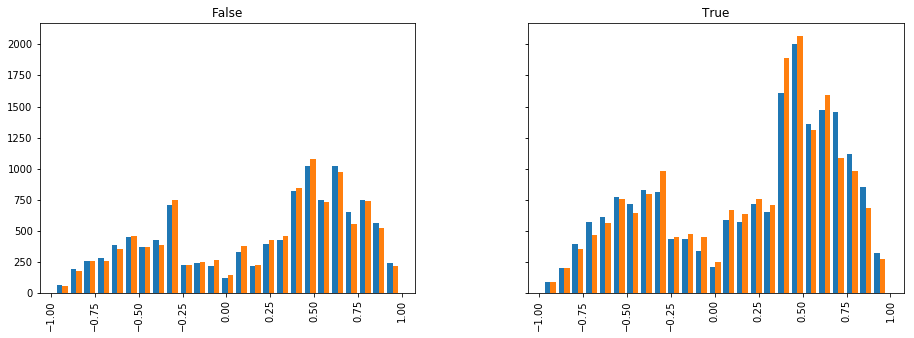

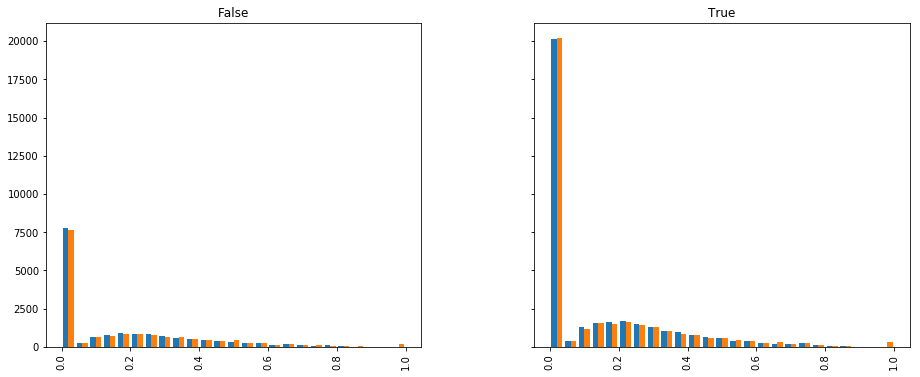

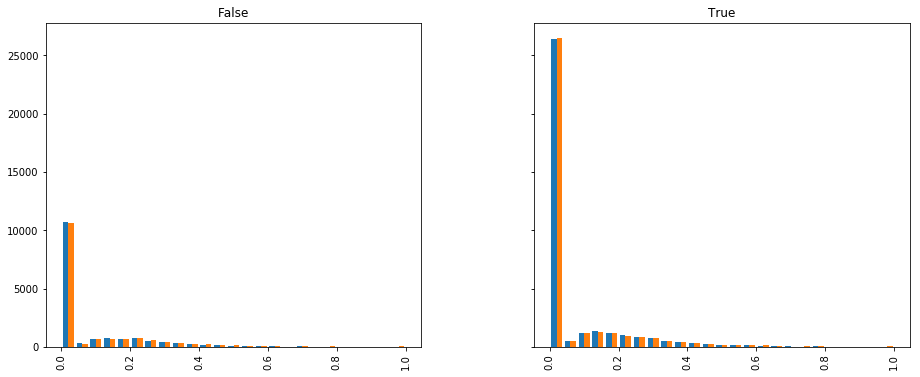

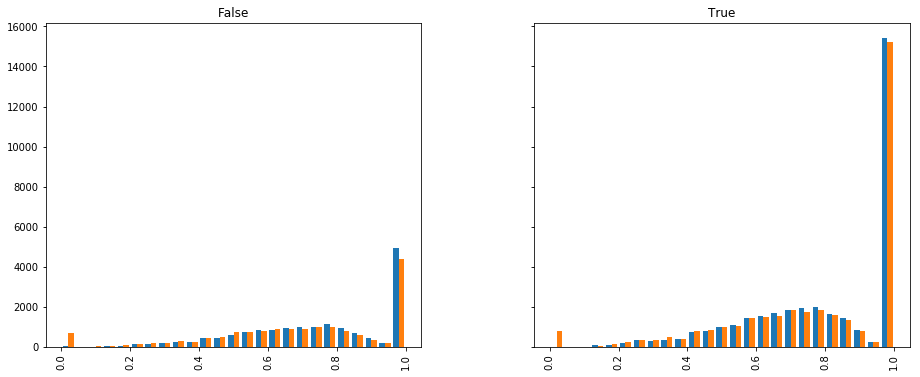

In [249]:
analysed_users['is_support'] = (analysed_users['follows_sg'] == True) | (analysed_users['follows_professional_sg'] == True)
analysed_users.loc[(analysed_users['compound_np'] != 0) & (analysed_users['compound'] != 0)][['compound_np','compound']].hist(bins=25, by=analysed_users['is_support'],figsize=(15,5), sharex=True, sharey=True)
analysed_users[['pos_np','pos']].hist(bins=25, by=analysed_users['is_support'], figsize=(15,6), sharex=True, sharey=True)
analysed_users[['neg_np','neg']].hist(bins=25, by=analysed_users['is_support'], figsize=(15,6), sharex=True, sharey=True)
analysed_users[['neu_np','neu']].hist(bins=25, by=analysed_users['is_support'], figsize=(15,6), sharex=True, sharey=True)

In [250]:
np.unique(analysed_users.is_support, return_counts=True)

(array([False,  True]), array([16291, 35582]))

In [251]:
cols = ['compound', 'pos', 'neg', 'neu']
cols_np = ['compound_np', 'pos_np', 'neg_np', 'neu_np']

In [252]:
analysed_users.shape

(51873, 21)

### Users with support groups

In [253]:
analysed_users[analysed_users['is_support'] == True][cols].describe()

compound           pos           neg           neu
count  35582.000000  35582.000000  35582.000000  35582.000000
mean       0.106597      0.141929      0.067196      0.780926
std        0.376557      0.209543      0.142944      0.248015
min       -0.970900      0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000      0.625000
50%        0.000000      0.000000      0.000000      0.833000
75%        0.401900      0.244000      0.063000      1.000000
max        0.977100      1.000000      1.000000      1.000000

### Users without support groups

In [254]:
analysed_users[analysed_users['is_support'] == False][cols].describe()

compound           pos           neg           neu
count  16291.000000  16291.000000  16291.000000  16291.000000
mean       0.129616      0.179705      0.092920      0.700120
std        0.439828      0.224247      0.161633      0.265045
min       -0.970000      0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000      0.543000
50%        0.000000      0.097000      0.000000      0.728000
75%        0.493900      0.309000      0.157000      1.000000
max        0.985400      1.000000      1.000000      1.000000

### Users without support groups

In [255]:
analysed_users.loc[(analysed_users['is_support'] == True) & (analysed_users['compound_np'] !=0) & (analysed_users['compound'] !=0) ][['compound_np','compound']].describe()

compound_np      compound
count  19157.000000  19157.000000
mean       0.199270      0.187027
std        0.508725      0.489395
min       -0.974400     -0.970900
25%       -0.296000     -0.273200
50%        0.381800      0.361200
75%        0.621900      0.585900
max        0.972500      0.977100

### Users with support groups

In [256]:
analysed_users.loc[(analysed_users['is_support'] == False) & (analysed_users['compound_np'] !=0) & (analysed_users['compound'] !=0) ][['compound_np','compound']].describe()

compound_np      compound
count  11155.000000  11155.000000
mean       0.193287      0.187021
std        0.526882      0.516436
min       -0.973200     -0.970000
25%       -0.296000     -0.296000
50%        0.361200      0.361200
75%        0.636000      0.612400
max        0.985400      0.985400

# Network Analysis